## In this notebook

- Create a model with (longer) memory.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.
- Used [this tutorial](https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e).

In [1]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score,
)
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Bidirectional, Dense, LSTM, RepeatVector, TimeDistributed


# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No such file or directory']
  warnings.warn(f"file system plugin

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

TIMESTEP = 96
Y_COLUMN = "available"

In [4]:
! ls -l $DATA_FOLDER

total 181500
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*95*1,0,0,0,3,95,5,22202,48.86851,2.295469,75016,west
1851079,2021-02-18 23:45:00,FR*V75*EBELI*96*1,2,1,0,0,95,5,22202,48.83550,2.349650,75013,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*97*1,1,1,1,0,95,5,22202,48.83995,2.397822,75012,east
1851081,2021-02-18 23:45:00,FR*V75*EBELI*98*1,2,0,1,0,95,5,22202,48.84998,2.361920,75004,south
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


In [6]:
# leave only one target in the data set

df = df.loc[:, ["date", "station", Y_COLUMN]]
df = df.sort_values(by="date").reset_index(drop=True)

df.tail()

,date,station,available
1851078,2021-02-18 23:45:00,FR*V75*EBELI*32*1,3
1851079,2021-02-18 23:45:00,FR*V75*EBELI*31*1,2
1851080,2021-02-18 23:45:00,FR*V75*EBELI*30*1,2
1851081,2021-02-18 23:45:00,FR*V75*EBELI*39*1,1
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3


## Prepare data for model

- Reshape data into `TIMESTEP` long slided windows, for both X and Y.
- Example `TIMESTEP = 4`:

```
+----------------------+----------------------+
| X                    | y                    |
+----------------------+----------------------+
| x_1, x_2, x_3, x_4   | x_5, x_6, x_7, x_8   |
| x_2, x_3, x_4, x_5   | x_6, x_7, x_8, x_9   |
| x_3, x_4, x_5, x_6   | x_7, x_8, x_9, x_10  |
-----------------------+----------------------+
```

In [7]:
%%time

X = []
y = []
window_size = 2 * TIMESTEP

for station in df.station.unique():
    target_col_array = (
        df
        .loc[df.station == station, Y_COLUMN]
        .values
    )
    
    for j in range(len(target_col_array) - window_size + 1):
        window = target_col_array[j: j + window_size]
        X.append(window[:TIMESTEP])
        y.append(window[TIMESTEP:])


# TODO: delete this data filtering (!!!)
X = X[:10_000]
y = y[:10_000]

X = np.reshape(X, (len(X), TIMESTEP, 1))
y = np.reshape(y, (len(y), TIMESTEP, 1))    

print(X.shape)
print(y.shape)

(10000, 96, 1)
(10000, 96, 1)
CPU times: user 6.35 s, sys: 78.5 ms, total: 6.43 s
Wall time: 6.43 s


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build model

In [9]:
# run model

# specify the architecture of LSTM
model = Sequential(name="LSTM-Model")
model.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name="Input-Layer"))
model.add(Bidirectional(
    LSTM(units=32, activation="tanh", recurrent_activation="sigmoid", stateful=False), 
    name="Hidden-LSTM-Encoder-Layer",
))
model.add(RepeatVector(y_train.shape[1], name="Repeat-Vector-Layer"))
model.add(Bidirectional(
    LSTM(units=32, activation="tanh", recurrent_activation="sigmoid", stateful=False, return_sequences=True), 
    name="Hidden-LSTM-Decoder-Layer",
))
model.add(TimeDistributed(Dense(units=1, activation="linear"), name="Output-Layer"))

# compile the model
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["MeanSquaredError", "MeanAbsoluteError"],
    loss_weights=None,
    run_eagerly=None,
    steps_per_execution=None
)

# fit model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    # epochs=1000, 
    epochs=100,
    validation_split=0.2,
    workers=4,
    use_multiprocessing=True,
)

Epoch 1/100
200/200 [==============================] - 7s 27ms/step - loss: 0.6297 - mean_squared_error: 0.6297 - mean_absolute_error: 0.6269 - val_loss: 0.4584 - val_mean_squared_error: 0.4584 - val_mean_absolute_error: 0.5652
Epoch 2/100
200/200 [==============================] - 5s 25ms/step - loss: 0.4640 - mean_squared_error: 0.4640 - mean_absolute_error: 0.5714 - val_loss: 0.4452 - val_mean_squared_error: 0.4452 - val_mean_absolute_error: 0.5678
Epoch 3/100
200/200 [==============================] - 5s 25ms/step - loss: 0.4568 - mean_squared_error: 0.4568 - mean_absolute_error: 0.5672 - val_loss: 0.4427 - val_mean_squared_error: 0.4427 - val_mean_absolute_error: 0.5497
Epoch 4/100
200/200 [==============================] - 5s 25ms/step - loss: 0.4553 - mean_squared_error: 0.4553 - mean_absolute_error: 0.5653 - val_loss: 0.4374 - val_mean_squared_error: 0.4374 - val_mean_absolute_error: 0.5453
Epoch 5/100
200/200 [==============================] - 5s 25ms/step - loss: 0.4498 - mea

Epoch 37/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3718 - mean_squared_error: 0.3718 - mean_absolute_error: 0.4643 - val_loss: 0.3676 - val_mean_squared_error: 0.3676 - val_mean_absolute_error: 0.4595
Epoch 38/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3718 - mean_squared_error: 0.3718 - mean_absolute_error: 0.4635 - val_loss: 0.3651 - val_mean_squared_error: 0.3651 - val_mean_absolute_error: 0.4610
Epoch 39/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3683 - mean_squared_error: 0.3683 - mean_absolute_error: 0.4594 - val_loss: 0.3680 - val_mean_squared_error: 0.3680 - val_mean_absolute_error: 0.4582
Epoch 40/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3644 - mean_squared_error: 0.3644 - mean_absolute_error: 0.4548 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - val_mean_absolute_error: 0.4572
Epoch 41/100
200/200 [==============================] - 5s 27ms/step - loss: 0.3662 

Epoch 73/100
200/200 [==============================] - 6s 28ms/step - loss: 0.2846 - mean_squared_error: 0.2846 - mean_absolute_error: 0.3758 - val_loss: 0.2911 - val_mean_squared_error: 0.2911 - val_mean_absolute_error: 0.3753
Epoch 74/100
200/200 [==============================] - 6s 28ms/step - loss: 0.2807 - mean_squared_error: 0.2807 - mean_absolute_error: 0.3713 - val_loss: 0.2857 - val_mean_squared_error: 0.2857 - val_mean_absolute_error: 0.3708
Epoch 75/100
200/200 [==============================] - 6s 29ms/step - loss: 0.2830 - mean_squared_error: 0.2830 - mean_absolute_error: 0.3740 - val_loss: 0.2982 - val_mean_squared_error: 0.2982 - val_mean_absolute_error: 0.3776
Epoch 76/100
200/200 [==============================] - 6s 28ms/step - loss: 0.2805 - mean_squared_error: 0.2805 - mean_absolute_error: 0.3712 - val_loss: 0.2856 - val_mean_squared_error: 0.2856 - val_mean_absolute_error: 0.3879
Epoch 77/100
200/200 [==============================] - 6s 28ms/step - loss: 0.2773 

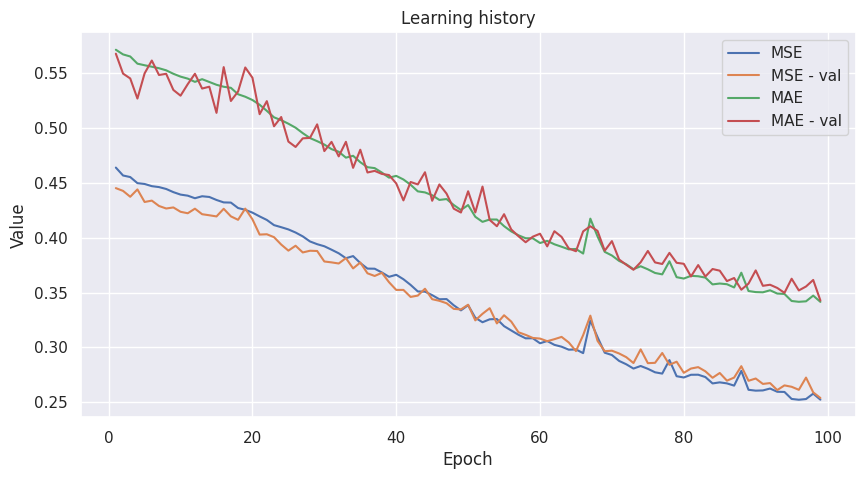

In [10]:
df_history = pd.DataFrame({
    # "loss": history.history["loss"],
    "MSE": history.history["mean_squared_error"],
    "MSE - val": history.history["val_mean_squared_error"],
    "MAE": history.history["mean_absolute_error"],
    "MAE - val": history.history["val_mean_absolute_error"],
})

ax = df_history.iloc[1:].plot(title="Learning history")
ax.set_xlabel("Epoch")
ax.set_ylabel("Value")

plt.show()

## Validate model

In [17]:
# check performance on test dataset

y_test_pred = np.round(
    np.clip(
        model.predict(X_test).reshape(1, -1)[0],
        a_min=0,
        a_max=3,
    )
)
y_test = y_test.reshape(1, -1)[0]

print("Results:")
print(f"- accuracy: {accuracy_score(y_test, y_test_pred):,.3f}")
print(f"- precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):,.3f}")
print(f"- recall: {recall_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):,.3f}")
print()
print(f"- confusion matrix: \n{confusion_matrix(y_test, y_test_pred)}")

63/63 [==============================] - 1s 9ms/step
Results:
- accuracy: 0.761
- precision: 0.758
- recall: 0.761
- F1: 0.750

- confusion matrix: 
[[   399    439    877   1057]
 [    21   2120   7581   1219]
 [     2   1143  36568  17820]
 [    16     70  15556 107112]]


<AxesSubplot: >

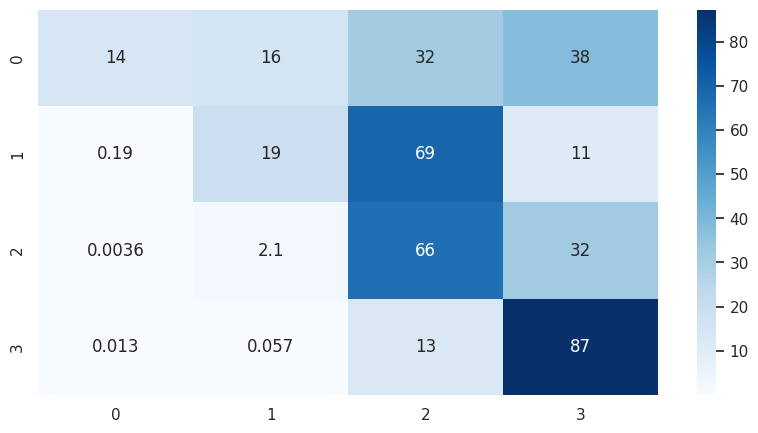

In [18]:
# check confusion matrix (with shares in every true class=rows)

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm / cm.sum(axis=1).reshape(-1, 1) * 100, 
    annot=True,
    cmap='Blues',
)

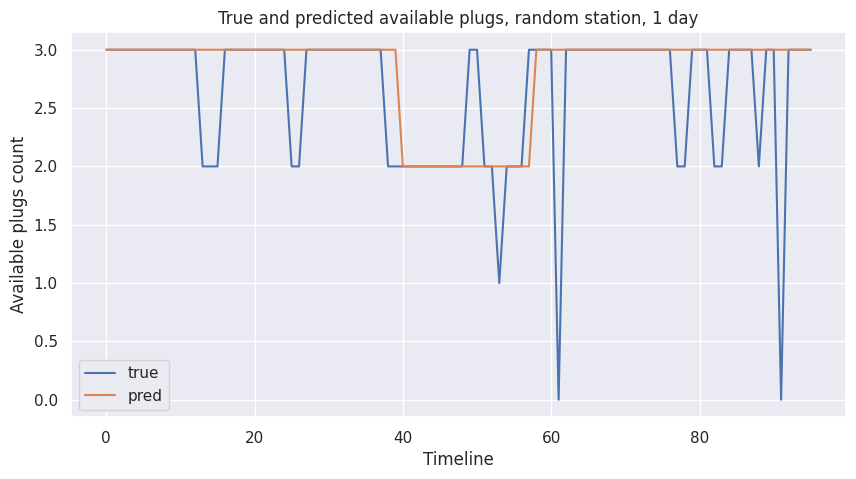

In [19]:
# check comparison of true and predicted available plugs

df_results = pd.DataFrame({
    "true": y_test,
    "pred": y_test_pred,
})

# ax = df_results.plot(alpha=0.75)
ax = df_results.head(96).plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs, random station, 1 day")

plt.show()

## Try to predict one station for the next 7 days

In [20]:
DATA_POINTS_TO_PREDICT = 96 * 7

In [21]:
%%time

most_frequent_station = df.station.value_counts().index[0]
last_values = (
    df
    .loc[df.station == most_frequent_station]
    .available
    .tail(TIMESTEP)
    .astype(float)
    .to_list()
)
preds = []

for i in range(DATA_POINTS_TO_PREDICT):
    if i > 0:
        last_values.pop(0)
        last_values.append(pred)
    
    pred = model.predict(np.array(last_values).reshape(1, TIMESTEP, 1), verbose=0)[0][0][0]
    preds.append(pred)

CPU times: user 22.4 s, sys: 1.06 s, total: 23.5 s
Wall time: 19 s


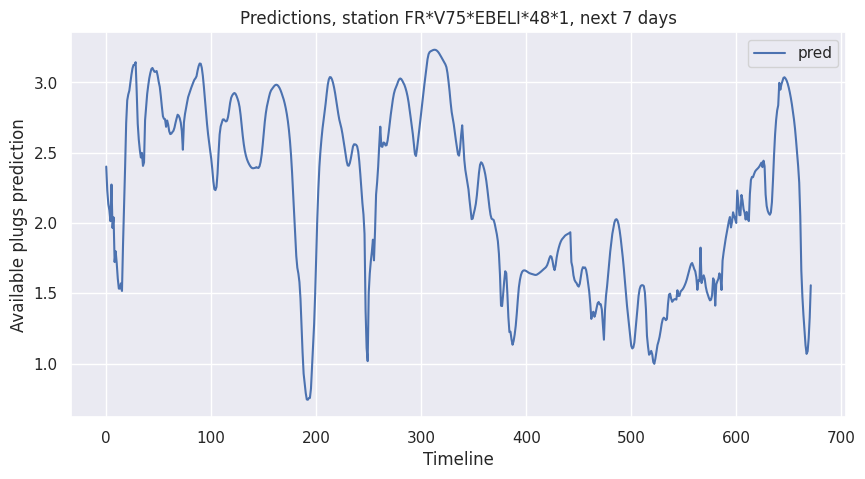

In [22]:
df_preds = pd.DataFrame({
    "pred": preds,
})

ax = df_preds.plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs prediction")
ax.set_title(f"Predictions, station {most_frequent_station}, next {DATA_POINTS_TO_PREDICT / 96:,.0f} days")

plt.show()

## Results

- Created a memory model.
- The results are following:
    - accuracy: 0.761
    - precision: 0.758
    - recall: 0.761
    - F1: 0.750
- The model looks like it can be used for long term predictions.